# Toy example to demonstrate the importance of the repulsive term in the energy distance
This notebook reproduces Figure 1 from *A Spectral Energy Distance for Parallel Speech Synthesis* ([https://arxiv.org/abs/2008.01160](https://arxiv.org/abs/2008.01160)). In this paper we use a spectrogram-based generalization of the *Energy Distance* ([wikipedia](https://en.wikipedia.org/wiki/Energy_distance)), which is a proper scoring rule for fitting generative models. The squared energy distance is given by $D^{2}[p|q] = 2\mathbb{E}_{\mathbf{x} \sim p, \mathbf{y} \sim q}||\mathbf{x} - \mathbf{y}||_{2} - \mathbb{E}_{\mathbf{x},\mathbf{x'} \sim p}||\mathbf{x} - \mathbf{x'}||_{2} - \mathbb{E}_{\mathbf{y},\mathbf{y'} \sim q}||\mathbf{y} - \mathbf{y'}||_{2}$. When $p$ is our data distribution and $q$ our model distribution this simplifies to a training loss given by $L[q] = 2\mathbb{E}_{\mathbf{x} \sim p, \mathbf{y} \sim q}||\mathbf{x} - \mathbf{y}||_{2} - \mathbb{E}_{\mathbf{y},\mathbf{y'} \sim q}||\mathbf{y} - \mathbf{y'}||_{2}$. The first term here *attracts* the model samples $\mathbf{y}$ towards the data samples $\mathbf{x}$, while the second term *repels* independent model samples $\mathbf{y}, \mathbf{y'}$ away from each other. In this notebook we estimate 2 simple toy models with and without using this repulsive term to demonstrate its importance.

## Imports

In [ ]:
import numpy as np
from scipy.optimize import minimize
import functools
import matplotlib.pyplot as plt
import palettable

## This is the energy distance loss

In [ ]:
def loss(param, sample_from_param_fun, real_data, repulsive_term = True):
  """ Energy Distance loss function for training a generative model.
  Inputs:
    param: parameters of a generative model
    sample_from_param_fun: function that produces a set of samples from the model for given parameters
    real_data: training data
    repulsive_term: whetther to include the repulsive term in the loss or not
  Output:
    A scalar loss that can be minimized to fit our model to the data
  """
  sample = sample_from_param_fun(param)
  d_real_fake = np.sqrt(np.sum(np.square(sample - real_data), axis=1))
  perm = np.random.RandomState(seed=100).permutation(sample.shape[0])
  sample2 = sample[perm] # we randomly match up independently generated samples
  d_fake_fake = np.sqrt(np.sum(np.square(sample - sample2), axis=1))
  l = 2. * np.mean(d_real_fake)
  if repulsive_term:
    l -= np.mean(d_fake_fake)
  return l

## Fitting a high dimensional Gaussian using energy distance, with and without using a repulsive term
We fit a high dimensional Gaussian model to training data generated from a distribution in the same model class. We show samples from the model trained by minimizing the energy distance (blue) or the more commonly used loss without repulsive term (green), and compare to samples from the training data (red). Samples from the energy distance trained model are representative of the data, and all sampled points lie close to training examples. Samples from the model trained without repulsive term are not typical of training data.

In [ ]:
n = 10000
dim = 100
def sample_from_param(param, z):
  mu = param[:-1]
  log_sigma = param[-1]
  sigma = np.exp(log_sigma)
  mu = np.reshape(mu, [1, dim])
  return mu + sigma * z

z_optim = np.random.normal(size=(n, dim))
sample_from_param_partial = functools.partial(sample_from_param, z=z_optim)

In [ ]:
# real data
real_param = np.zeros(dim+1)
real_data = sample_from_param(real_param, np.random.normal(size=(n, dim)))

In [ ]:
# with energy distance
res = minimize(loss,
               np.zeros(dim + 1),
               args=(sample_from_param_partial, real_data, True),
               method='BFGS',
               tol=1e-10)
sample_ged = sample_from_param_partial(res.x)

In [ ]:
# without repulsive
res = minimize(loss,
               np.zeros(dim + 1),
               args=(sample_from_param_partial, real_data, False),
               method='BFGS',
               tol=1e-10)
sample_naive = sample_from_param_partial(res.x)

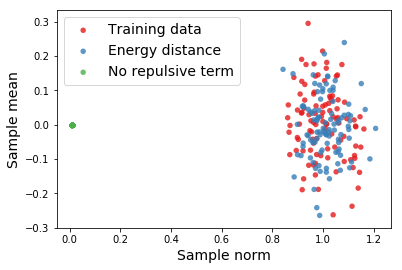

In [ ]:
def data_to_xy(sample):
  sample = sample[:100]
  x = np.sqrt(np.mean(np.square(sample), axis=1))
  y = np.mean(sample, axis=1)
  return (x,y)

data = (data_to_xy(real_data), data_to_xy(sample_ged), data_to_xy(sample_naive))
colors = palettable.colorbrewer.qualitative.Set1_3.mpl_colors
groups = ("Training data", "Energy distance", "No repulsive term")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
  x, y = data
  ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.legend(loc='best', fontsize=14)
plt.xlabel('Sample norm', fontsize=14)
plt.ylabel('Sample mean', fontsize=14)
plt.show()

## Fitting a mixture of 3 Gaussians in 2d
We fit a mixture of 3 Gaussians in 2d to training data generated from a distribution in the same model class. We show samples from the model trained by minimizing the energy distance (blue) or the more commonly used loss without repulsive term (green), and compare to samples from the training data (red). Samples from the energy distance trained model are representative of the data, and all sampled points lie close to training examples. Samples from the model trained without repulsive term are not typical of training data.

In [ ]:
n = 10000
def sample_from_param(param, z, perm):
  params = np.split(param, 3)
  means = [np.reshape(p[:2], [1,2]) for p in params]
  sigmas = [np.exp(p[2]) for p in params]
  samples = [m + s*zi for m,s,zi in zip(means, sigmas, z)]
  samples = np.concatenate(samples, axis=0)[perm]
  return samples

z_optim = np.split(np.random.normal(size=(n, 6)), 3, axis=1)
perm_optim = np.random.permutation(3*n)
sample_from_param_partial = functools.partial(sample_from_param,
                                              z=z_optim,
                                              perm=perm_optim)

In [ ]:
# real data
real_param = np.array([-10., 0., 0., 10., 0., 0., 0., np.sqrt(300.), 0.])
z_real = np.split(np.random.normal(size=(n, 6)), 3, axis=1)
perm_real = np.random.permutation(3*n)
real_data = sample_from_param(real_param, z=z_real, perm=perm_real)

In [ ]:
# with energy distance
res = minimize(loss,
               np.zeros(9),
               args=(sample_from_param_partial, real_data, True),
               method='BFGS',
               tol=1e-10)
sample_ged = sample_from_param_partial(res.x)

In [ ]:
# without repulsive
res = minimize(loss,
               np.zeros(9),
               args=(sample_from_param_partial, real_data, False),
               method='BFGS',
               tol=1e-10)
sample_naive = sample_from_param_partial(res.x)

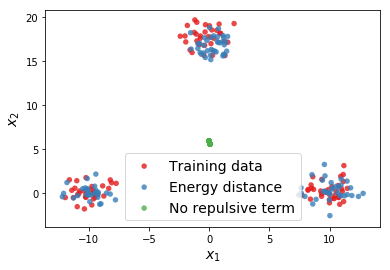

In [ ]:
def data_to_xy(sample):
  sample = sample[:100]
  x,y = np.split(sample,2,axis=1)
  return (x,y)

data = (data_to_xy(real_data), data_to_xy(sample_ged), data_to_xy(sample_naive))
colors = palettable.colorbrewer.qualitative.Set1_3.mpl_colors
groups = ("Training data", "Energy distance", "No repulsive term")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
  x, y = data
  ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.legend(loc='best', fontsize=14)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.show()

## Copyright

Copyright 2020 The Google Research Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.